# <span style="color:blue"> MBA em Ciência de Dados</span>
# <span style="color:blue">Aprendizado Dinâmico</span>

## <span style="color:blue">Avaliação Final</span>

### Aluno: Benicio Ramos Magalhães

**Material Produzido por Cibele Russo**<br>
**Cemeai - ICMC/USP São Carlos**

##### Para esta avaliação, você deve entregar três arquivos:
    ● um arquivo de dados em .csv com a base resultante das análises
    ● um relatório em .ipynb com suas análises comentadas
    ● um arquivo .pdf gerado a partir do .ipynb

##### Os dados de casos confirmados e mortes diárias por COVID-19 nos Estados Unidos estão disponíveis no arquivo covid19USA.csv. 

In [3]:
#bibliotecas
import six
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from pmdarima import auto_arima 
sys.modules['sklearn.externals.six'] = six
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import warnings; warnings.simplefilter('ignore')
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Exercício 1

#### Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os dados estão corretos e realizar algum procedimento necessário caso haja dados faltantes. 

In [4]:
#leitura dos dados estabelecendo um índice por datas
data = pd.read_csv('.\covid19USA.csv',index_col='date',parse_dates=True)
data.head()

,confirmed,deaths
date,,
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


 ___________________________________________________________
|                    Verificação de dados                   |
|___________________________________________________________|
|Início:----------------------------| 2020-01-01 00:00:00 --|
|Fim:-------------------------------| 2020-09-03 00:00:00 --|
|Tipo de dado do índice:------------| datetime64[ns] -------|
|Tamanho da base original:----------| 247 ------------------|
|Tamanho esperado para o intervalo:-| 247 ------------------|
|Dados Faltantes em confirmed:------| 0 --------------------|
|Dados Faltantes em deaths:---------| 0 --------------------|
|___________________________________________________________|


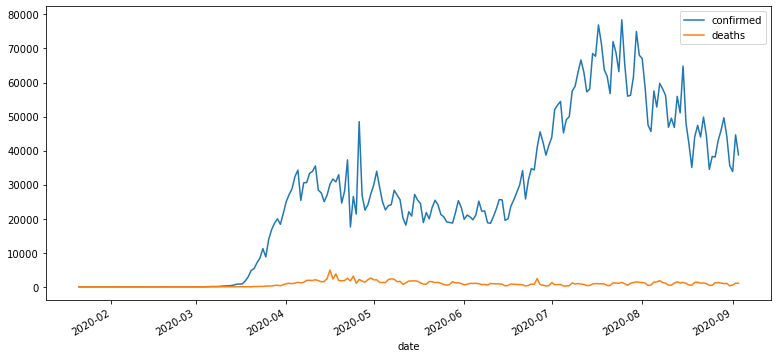

In [5]:
#verificando se os dados estão corretos

#checando intervalos de datas e tamanho do da base:
print(' ___________________________________________________________')
print('|                    Verificação de dados                   |')
print('|___________________________________________________________|')
print('|Início:----------------------------|',data.index.min(),'--|')
print('|Fim:-------------------------------|',data.index.max(),'--|')
print('|Tipo de dado do índice:------------|',data.index.dtype,'-------|')
print('|Tamanho da base original:----------|',len(data),'------------------|')
print('|Tamanho esperado para o intervalo:-|',len(pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')),'------------------|')

#verifcando se temos dados faltantes:
print('|Dados Faltantes em confirmed:------|',len(data[data['confirmed'].isnull()]),'--------------------|')
print('|Dados Faltantes em deaths:---------|',len(data[data['deaths'].isnull()]),'--------------------|')
print('|___________________________________________________________|')

#printando os dados:
rcParams['figure.figsize'] = 13, 6
data[data['confirmed']>0].plot();

    Conforme observamos na base de dados, não verificamos necessidade de aplicar algum procedimento para dados faltantes.

### Exercício 2

#### Proponha uma decomposição dos dados de mortes em tendência e sazonalidade. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente brevemente os resultados.

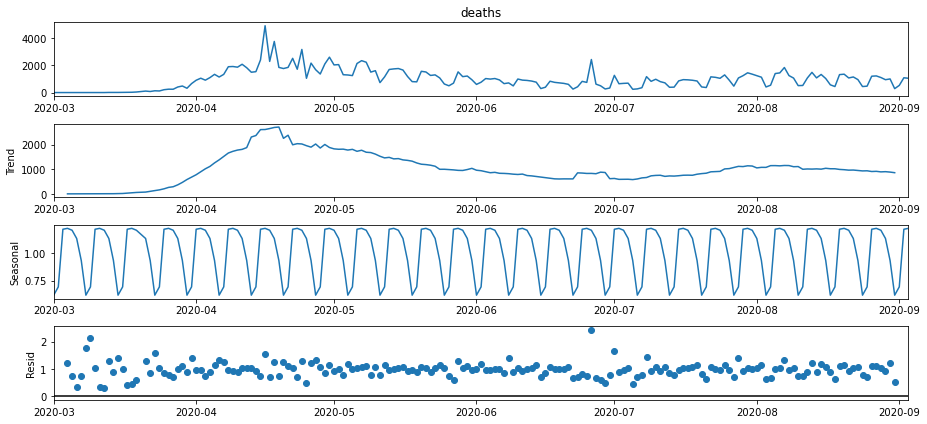

In [6]:
#decomposição dos dados de mortes em tendência e sazonalidade:
decomposicao = seasonal_decompose(data[data['deaths']>0]['deaths'],model='multiplicative', period=7)
fig = decomposicao.plot()

In [7]:
#testando a estacionariedade
result = adfuller(data['deaths'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.389673
p-value: 0.144672
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


###### Análise de tendência:
        É possível observar uma tendência crescente no período de abril. A curva segue depois com uma tendência decrescente até meados de junho. No final de junho, temos um pequeno período de elevação, seguido logo de queda. Depois desse período a tendência fica muito menos evidente, praticamente sugerindo uma estacionaridade, porém, como os testes de Dickey-Fuller realizados anteriormente com p-valor maior que 0.05, rejeitamos a hipótese de estacionariedade na série.

###### Análise de sazonalidade:
        Podemos observar ciclos semanais que provavelmente são explicadas pela sistemática de notificações, onde os dados ficam acumulados para cálculo no ínicio da semana e são sumarizados e apresentados mais para o meio da semana. Com relação ao tipo de sazonalidade, o gráfico apresenta algumas variações ao longo da série temporal, principalmente nos períodos de tendência crescente, portanto, consideramos mais adequada representarmos a sazonalidade como sendo do tipo multiplicativa.

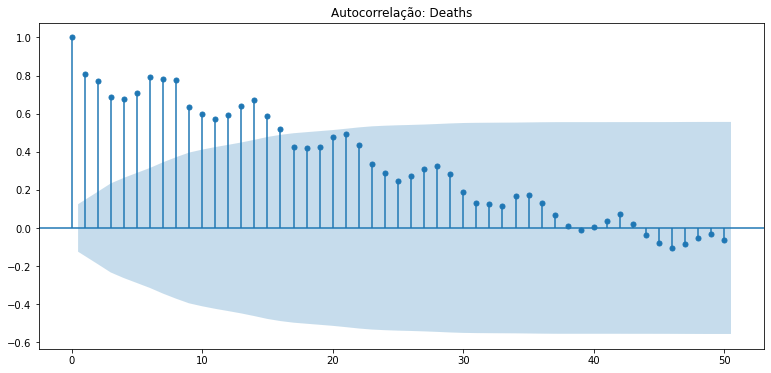

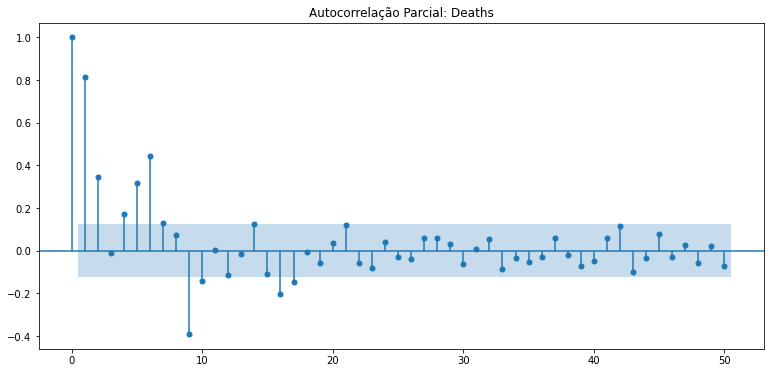

In [8]:
#gráficos de autocorrelação e autocorrelação parcial
fig = plot_acf(data['deaths'],title='Autocorrelação: Deaths',lags=50)
fig = plot_pacf(data['deaths'],title='Autocorrelação Parcial: Deaths',lags=50)

###### Análise de autocorrelação:
        Podemos observar que a correlação entre a série original até a série com atraso lag=16 são bastante significativas pois encontram-se maiores que o intervalo de confiança (área azul), portanto, precisamos levá-las em consideração durante a modelagem. Notamos também que há presença de sazonalidade nos dados, apresentando vales e picos em ciclos de 7 dias.
        
###### Análise de autocorrelação parcial:  
        Podemos verificar que a partir do lag=3 a correlação cai bastante, apresentando valores por volta 0.4. Mesmo as correlações não sendo tão altas, elas ainda são importantes para o modelo, pois apresentam-se fora do intervalo de confiança.

### Exercício 3

#### Divida a base em treino e teste, com 21 observações na base de teste. Você deverá apresentar em distintas colunas na mesma base de dados que será entregue: 

          ● Os dados originais de casos confirmados e mortes. 
    
          ● As previsões de Holt e Holt Winters para a variável mortes. 
    
          ● As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido para a variável mortes. Identifique as componentes desse melhor modelo (por exemplo, “o modelo tem uma componente autorregressiva não sazonal de ordem.., uma componente de médias móveis não-sazonal de ordem.., etc). 
    
          ● As previsões obtidas por um modelo de redes dinâmicas para a variável mortes. 

In [9]:
#definindo uma semente (42! - the answer to everything)
np.random.seed(42)

#dividindo a base em treino e teste:
train = data.iloc[:226]
test = data.iloc[226:]

print('Base de treino:',len(train),'observações.')
print('Base de teste:',len(test),'observações.')

Base de treino: 226 observações.
Base de teste: 21 observações.


In [10]:
#métodos de suavização holt e holt-winters para a variável mortes:

#treinamento e predição pelo método de Holt
adjustH = ExponentialSmoothing(train['deaths'],trend='add').fit()
predictH = adjustH.forecast(21).rename('Previsão Holt')
predictH.index = data.index[226:]

#treinamento e predição pelo método de Holt-Winters
adjustHW = ExponentialSmoothing(train['deaths'],trend='add',seasonal='add',seasonal_periods=7).fit()
predictHW = adjustHW.forecast(21).rename('Previsão Holt-Winters')
predictHW.index = data.index[226:]

            confirmed  deaths       holt  holt-winters
date                                                  
2020-01-01          0       0   8.383989      8.177887
2020-01-02          0       0  10.737133     10.468893
2020-01-03          0       0  12.356743     12.166760
2020-01-04          0       0  13.471327     13.371696
2020-01-05          0       0  14.238206     14.261848


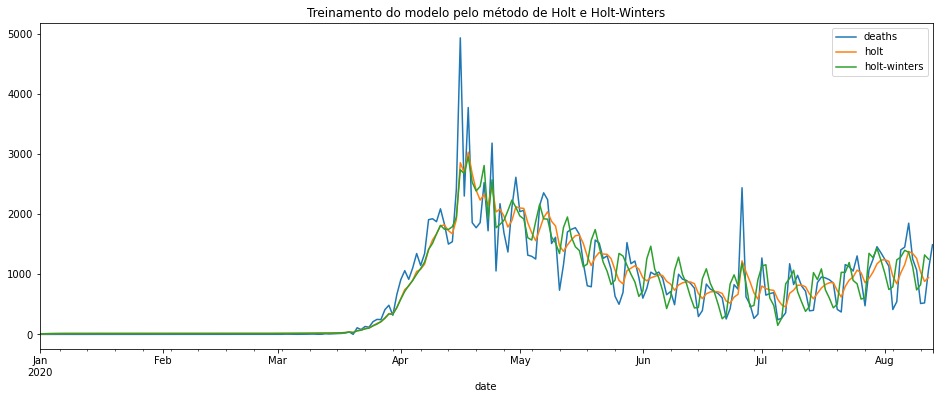

In [11]:
#imprimindo dados de treinamento modelados pelo método de holt e holt-winters

train['holt'] = adjustH.fittedvalues.shift(-1);
train['holt-winters'] = adjustHW.fittedvalues.shift(-1);
print(train.head())
fig = train[['deaths','holt','holt-winters']].plot(figsize=(16,6),title='Treinamento do modelo pelo método de Holt e Holt-Winters')

            confirmed  deaths         holt  holt-winters
date                                                    
2020-08-14      51094    1083  1120.581342   1425.505533
2020-08-15      64838    1336  1125.546155   1178.708462
2020-08-16      48085    1035  1130.510968    980.247421
2020-08-17      42104     571  1135.475780    585.397064
2020-08-18      35056     445  1140.440593    726.522397


<AxesSubplot:title={'center':'Predição do modelo pelo método de Holt e Holt-Winters'}, xlabel='date'>

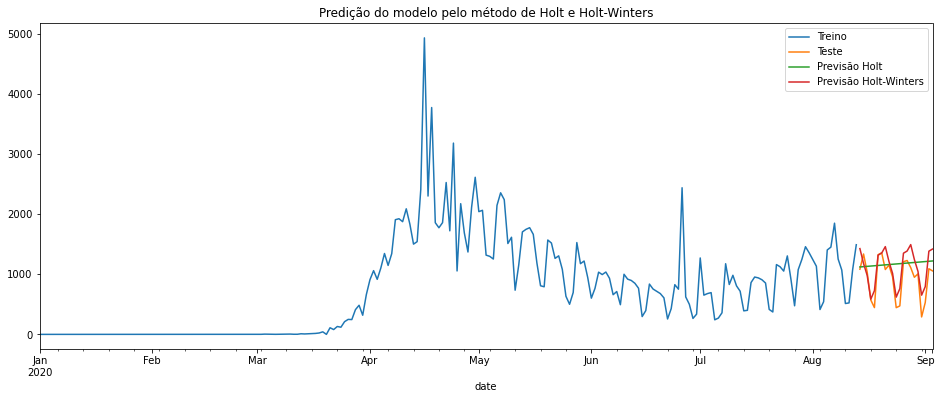

In [12]:
#imprimindo dados com a predição realizada pelo método de holt e holt-winters

test['holt'] = predictH
test['holt-winters'] = predictHW
print(test.head())
train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo pelo método de Holt e Holt-Winters')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
predictH.plot(legend=True,label='Previsão Holt')
predictHW.plot(legend=True,label='Previsão Holt-Winters')

In [13]:
# aplicando stepwise para selecionar o melhor modelo SARIMA

auto_arima(train['deaths'],seasonal=True,m=7).summary()

stepwise_fit = auto_arima(train['deaths'], start_p=0, start_q=0,max_p=6,max_q=3,m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          supress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=3418.337, BIC=3432.001, Fit time=0.156 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=3418.463, BIC=3425.295, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=3353.998, BIC=3367.663, Fit time=0.232 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=3349.966, BIC=3363.630, Fit time=0.349 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=3306.510, BIC=3323.591, Fit time=0.734 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=3340.881, BIC=3354.546, Fit time=0.293 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=3304.675, BIC=3325.171, Fit time=1.169 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=3300.207, BIC=3324.120, Fit time=1.331 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 2, 7); AIC=3306.376, BIC=3326.873, Fit time=1.139 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  226
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 7)   Log Likelihood               -1633.119
Date:                            Wed, 09 Sep 2020   AIC                           3284.239
Time:                                    22:43:22   BIC                           3314.984
Sample:                                         0   HQIC                          3296.648
                                            - 226                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.6011     14.299     -0.392      0.695     -33.626      22.424
ar.L1          0.8173      0.071     11.520      0.000       0.678       0.956
ar.L2         -0.4568      0.089     -5.133      0.000      -0.631      -0.282
ar.L3         -0.4185      0.064     -6.533      0.000      -0.544      -0.293
ma.L1         -1.5598      0.080    -19.531      0.000      -1.716      -1.403
ma.L2          1.2980      0.113     11.448      0.000       1.076       1.520
ma.L3         -0.3483      0.074     -4.689      0.000      -0.494      -0.203
ar.S.L7       -0.0497      0.056     -0.881      0.378      -0.160       0.061
sigma2      1.318e+05   5703.856     23.108      0.000    1.21e+05    1.43e+05
===================================================================================
Ljung-Box (Q):                       51.68   Jarque-Bera (JB):              6750.13
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):             464.93   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### Descrição do modelo selecionado: SARIMAX(3, 1, 3)x(1, 0, 0, 7)

    - Componente não sazonal autorregressiva de ordem 3
    - Componente não sazonal integrado de ordem 1
    - Componente não sazonal de médias móveis de ordem 3
    - Componente sazonal autorregressiva de primeira ordem com período 7
    - Sem componente sazonal integrada
    - Sem componente sazonal de média móvel

In [14]:
#treinamento utilizando o modelo SARIMA identificado pelo stepwise

adjustSARIMA = SARIMAX(train['deaths'],order=(3,1,3),seasonal_order=(1,0,0,7)).fit()
adjustSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             deaths   No. Observations:                  226
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 7)   Log Likelihood               -1631.614
Date:                            Wed, 09 Sep 2020   AIC                           3279.228
Time:                                    22:43:23   BIC                           3306.557
Sample:                                01-01-2020   HQIC                          3290.258
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8179      0.063     13.040      0.000       0.695       0.941
ar.L2         -0.4578      0.079     -5.788      0.000      -0.613      -0.303
ar.L3         -0.4142      0.056     -7.403      0.000      -0.524      -0.305
ma.L1         -1.5655      0.071    -22.156      0.000      -1.704      -1.427
ma.L2          1.2993      0.102     12.737      0.000       1.099       1.499
ma.L3         -0.3508      0.066     -5.313      0.000      -0.480      -0.221
ar.S.L7       -0.0502      0.045     -1.126      0.260      -0.138       0.037
sigma2      1.151e+05   3894.620     29.560      0.000    1.07e+05    1.23e+05
===================================================================================
Ljung-Box (Q):                       51.51   Jarque-Bera (JB):              6746.95
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):           54463.55   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
#predição utilizando o modelo SARIMA identificado pelo stepwise

start = len(train)
end = len(train) + len(test)-1
predict_SARIMA = adjustSARIMA.predict(start=start,end=end,dynamic=False,typ='levels').rename('Previsões SARIMA(3, 1, 3)x(1, 0, 0, 7)')
predict_SARIMA.index = test.index

date
2020-08-14    1493.331715
2020-08-15    1300.243922
2020-08-16     883.135011
2020-08-17     654.833988
2020-08-18     732.306818
Name: Previsões SARIMA(3, 1, 3)x(1, 0, 0, 7), dtype: float64


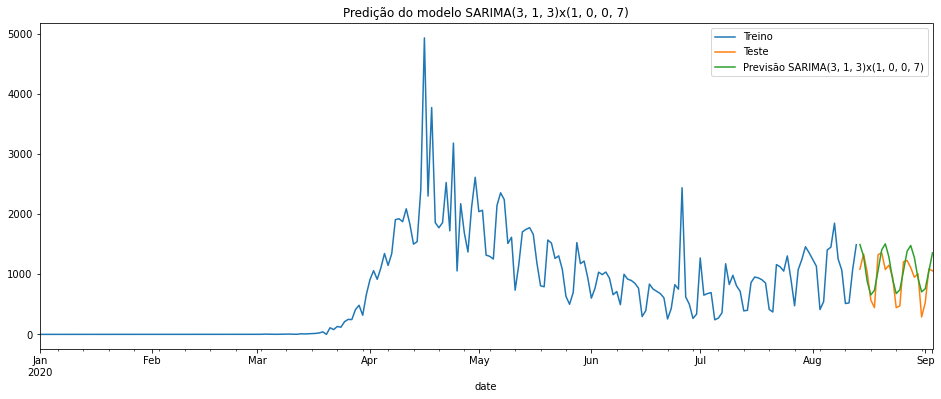

In [16]:
#imprimindo dados com a predição realizada pelo SARIMA

train['sarima'] = adjustSARIMA.fittedvalues
test['sarima'] = predict_SARIMA
print(predict_SARIMA.head())
train['deaths'].plot(legend=True,label='Treino',title='Predição do modelo SARIMA(3, 1, 3)x(1, 0, 0, 7)')
test['deaths'].plot(legend=True,label='Teste',figsize=(16,6))
fig = predict_SARIMA.plot(legend=True,label='Previsão SARIMA(3, 1, 3)x(1, 0, 0, 7)')

In [17]:
train

,confirmed,deaths,holt,holt-winters,sarima
date,,,,,
2020-01-01,0,0,8.383989,8.177887,0.000000
2020-01-02,0,0,10.737133,10.468893,0.000000
2020-01-03,0,0,12.356743,12.166760,0.000000
2020-01-04,0,0,13.471327,13.371696,0.000000
2020-01-05,0,0,14.238206,14.261848,0.000000
...,...,...,...,...,...
2020-08-09,56221,1069,1263.650580,739.131257,1073.541851
2020-08-10,46847,513,1034.718779,826.691805,826.008751
2020-08-11,49530,523,880.217974,1320.137577,877.059363


 ____________________________________________________________________________
|Intervalo de dados de treino:  | 0.0  -  1.0                                |
|____________________________________________________________________________|
|Intervalo de dados de teste:   | 0.0588474025974026  -  0.27516233766233766 |
|____________________________________________________________________________|


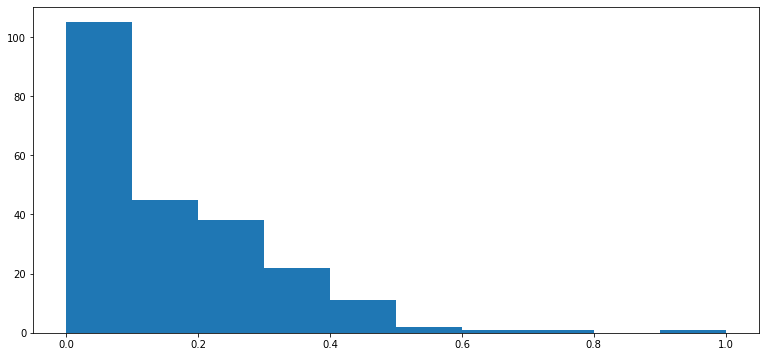

In [18]:
# padronizando os dados para aplicar modelo de redes dinâmicas

scaler = MinMaxScaler().fit(train['deaths'].values.reshape(-1,1))
scaled_train = scaler.transform(train['deaths'].values.reshape(-1,1))
scaled_test = scaler.transform(test['deaths'].values.reshape(-1,1))

print(' ____________________________________________________________________________')
print('|Intervalo de dados de treino:  |',scaled_train.min(),' - ',scaled_train.max(),'                               |')
print('|____________________________________________________________________________|')
print('|Intervalo de dados de teste:   |',scaled_test.min(),' - ',scaled_test.max(),'|')
print('|____________________________________________________________________________|')

fig = plt.hist(scaled_train)

### Exercício 4

#### Utilize o erro quadrático médio e erro absoluto médio para comparar as previsões obtidas com as observações da base de teste.

### Exercício 5

#### Considere o método que produziu a melhor previsão para os dados de teste e faça a previsão para mais 14 dias (além das observações da base de dados). Essa previsão pode ser apresentada com um gráfico nos arquivos .ipynb e .pdf. 